### Impedance Experiments
Objective: Test different impedance functions 

Based on paper


Vale, D. S., Saraiva, M., & Pereira, M. (2016). Active accessibility: A review of operational measures of walking and cycling accessibility. Journal of Transport and Land Use. University of Minnesota. https://doi.org/10.5198/jtlu.2015.593

In [1]:
# List of Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandana as pdna
import geopandas as gpd
from pandana.loaders import osm
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_point_X_Y(schools_dataframe):
    """ Returns two Coordinates Series (lat and long) from a point dataframe """
    schoolX = []
    schoolY = []
    for e in schools_dataframe[['geometry']].iterrows():
        schoolX.append(e[1].geometry.x)
        schoolY.append(e[1].geometry.y)
    schools_dataframe['schoolX'] = schoolX
    schools_dataframe['schoolY'] = schoolY
    return schools_dataframe


In [3]:
# Load data
portugal_polygon = gpd.read_file('../data/CONTINENTE/BGRI11_CONT.shp')

In [4]:
# Load Schools Data
schools = gpd.read_file('../data/escolas_portugal_corrigido/gdf_escolas_publicas_1CEB.shx')
schools = schools.to_crs({'init':'epsg:4326'})

In [5]:
# Select Aveiro(0105) and Ílhavo(0110) cities From Continental Portugal
aveiro_ilhavo_polygon = portugal_polygon[(portugal_polygon['DTMN11']=='0105') | (portugal_polygon['DTMN11']=='0110')]

In [6]:
# Adjust projection to wgs-84 and get subsection centroids
aveiro_ilhavo_polygon = aveiro_ilhavo_polygon.to_crs({'init': 'epsg:4326'})
aveiro_ilhavo_polygon['temp'] = 1
aveiro_ilhavo_shape = aveiro_ilhavo_polygon.dissolve(by='temp')
aveiro_ilhavo_centroids = aveiro_ilhavo_polygon.centroid


In [7]:
# Get only the schools that are inside Aveiro_Ilhavo Region
aveiro_ilhavo_schools = gpd.sjoin(schools[['ESCOLA','CÓD. DGPGF','geometry']],aveiro_ilhavo_shape[['geometry']],how='inner', op='intersects')
aveiro_ilhavo_schools = get_point_X_Y(aveiro_ilhavo_schools)

In [8]:
# Get Polygon Bounds
bounds = aveiro_ilhavo_polygon.total_bounds
bbox = [bounds[1], bounds[0], bounds[3], bounds[2]]

In [9]:
# Create Pandana Network
network = osm.pdna_network_from_bbox(*bbox)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](40.52848367,-8.76608888,40.72755360,-8.52096487);>;);out;'}"
Downloaded 9,994.4KB from www.overpass-api.de in 1.52 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.71 seconds
Returning OSM data with 76,923 nodes and 10,972 ways...
Edge node pairs completed. Took 17.42 seconds
Returning processed graph with 13,769 nodes and 19,418 edges...
Completed OSM data download and Pandana node and edge table creation in 21.34 seconds


In [10]:
# Create POIS and precompute
maxDistance = 10000
maxItems = 5
network.set_pois('schools', maxDistance, maxItems, aveiro_ilhavo_schools['schoolX'],aveiro_ilhavo_schools['schoolY'])
network.precompute(maxDistance)

In [11]:
# Generate the accessibility
accessibility = network.nearest_pois(1000, 'schools', num_pois=3, imp_name='distance')

### Impedance class definition
Used to apply different impedance functions on the accessibily dataframe

According to Vale (Vale et al., 2016) 

" ... gravity-based measures explicitly assume attenuation toward travel. Three functions are often used: inverse power, negative exponential, and modified Gaussian"

Parameters were established by analyzing the changes in the rate of decline and the point at which the function approaches zero (Figure 3). Specifically, we established different values (0.50, 0.25, 0.125, 0.062, and 0.031) of the function at different distances from origins. Fifty meters from the origin was chosen for power functions due to the high elasticity of the function near the origin, whereas for exponential measures we used 200 m. The parameters for Gaussian measures were established by setting the distance at which the function would take the value 0.50. The thresholds used for cumulative measures were based on the quarter-mile (400 m) rule of thumb, extended by intervals of 200 m. Finally, the cumulative–Gaussian parameters were chosen with two different criteria. CuGa1 and CuGa2 assume a 200m indifference travel distance and differ by altering the parameter of the Gaussian part. CuGa3 and CuGa4 assume a 400m indifference travel distance and also differ by altering the Gaussian part of the function.

Parameter a reflects
the acceptable pedestrian distance and parameter v reflects the slope of the curve after that initial distance.


In [38]:
class Impedance:
    
    def __init__(self, accessibility_dataframe):
        self.df = accessibility_dataframe
    
    def apply_impedance_functions(self):
        self.cumulative()
        self.inverse_power()
        self.negative_exponential()
        self.modified_gaussian()
        self.cumulative_gaussian()
        
        return self.df
    
    def cumulative(self, n=1, alpha=400):
        self.df['cumulative'] = self.df[n].apply(lambda x: 1 if x <= alpha else 0)
    
    def change_zeros(self, n=1, value=1):
        self.df['non_zeros'] = self.df[n].apply(lambda x: value if x==0 else x)
    
    def inverse_power(self, n=1, alpha=0.709):
        self.change_zeros(n=n)
        self.df['inverse_power'] = self.df['non_zeros'].apply(lambda x: x**(-alpha))
            
    def negative_exponential(self, n=1, beta=0.003):
        self.change_zeros(n=n)
        self.df['negative_exponential'] = self.df['non_zeros'].apply(lambda x: np.exp(-beta*x))
    
    def modified_gaussian(self, n=1, slope=57708):
        self.change_zeros(n=n)
        self.df['modified_gaussian'] = self.df['non_zeros'].apply(lambda x: np.exp(-(x**2)/slope))
        
    def cumulative_gaussian(self, n=1, alpha=400, slope=57708):
        self.change_zeros(n=n)
        self.df['cumulative_gaussian'] = self.df['non_zeros'].apply(lambda x: 1 if x<=alpha else np.exp(- ((x-alpha)**2 )/slope ) )
        

In [39]:
result = Impedance(accessibility)

In [40]:
impedance = result.apply_impedance_functions()

In [69]:
# Visualize the plot directly via matplotlib
def plot_functions(impedance_df, impedance_function=1):
    fig, ax = plt.subplots(figsize=(15,11))
    aveiro_ilhavo_shape.plot(ax=ax, facecolor='#DCDCDC', edgecolor='#B0C4DE')

    plt.title('Aveiro-Ílhavo: Nearest Schools - {}'.format(impedance_function))
    plt.scatter(network.nodes_df.x, network.nodes_df.y, 
                c=impedance_df[impedance_function], s=1, cmap='hot_r' 
                )
    cb = plt.colorbar()

    plt.show()

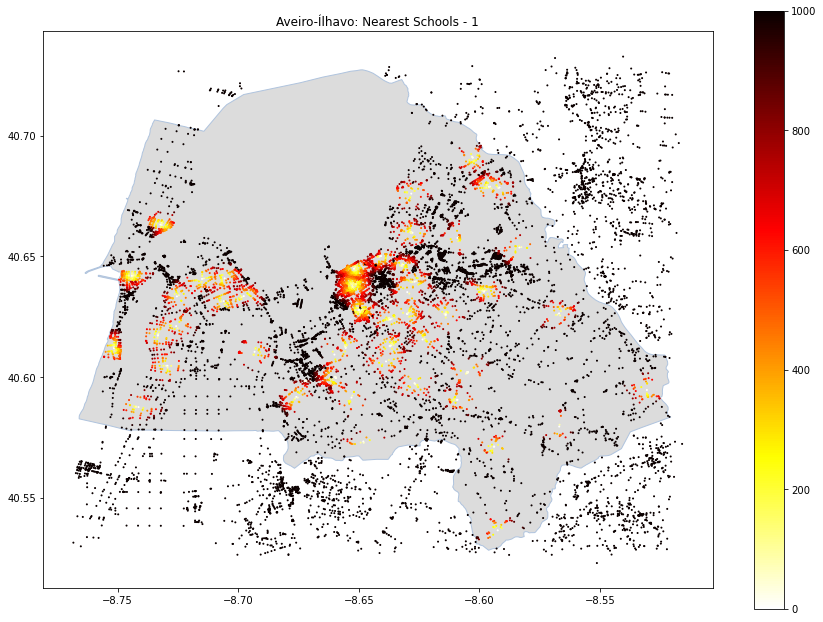

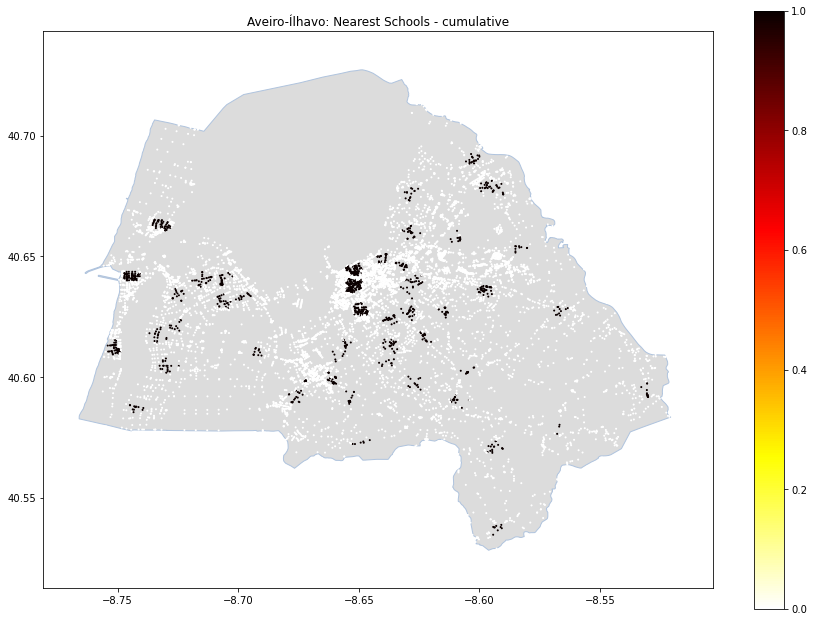

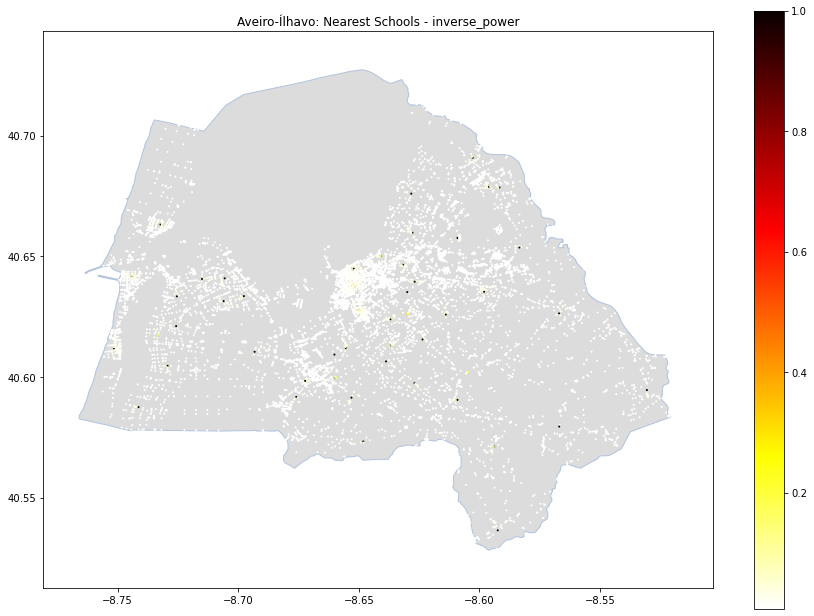

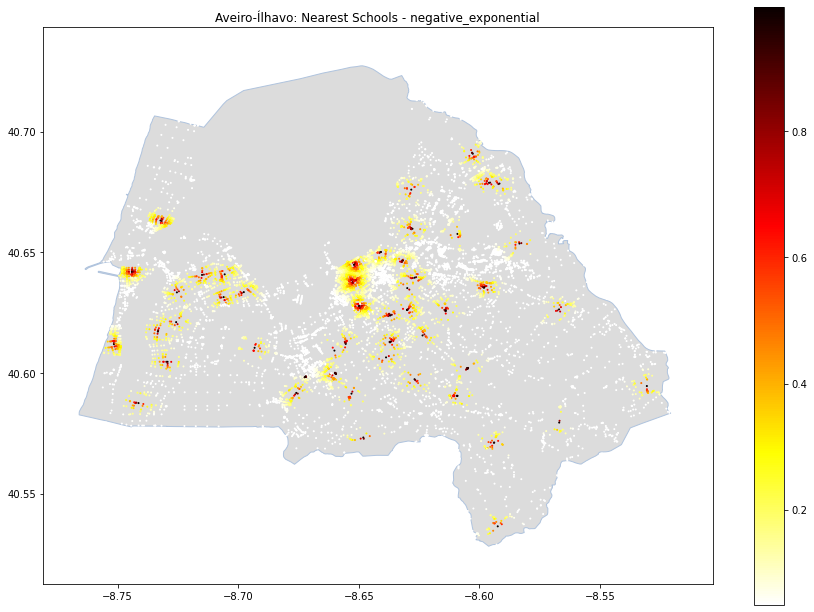

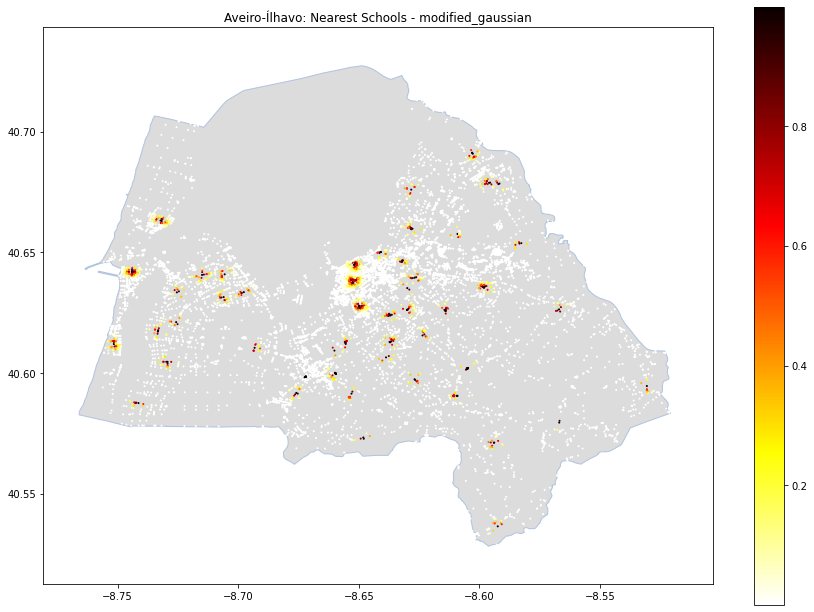

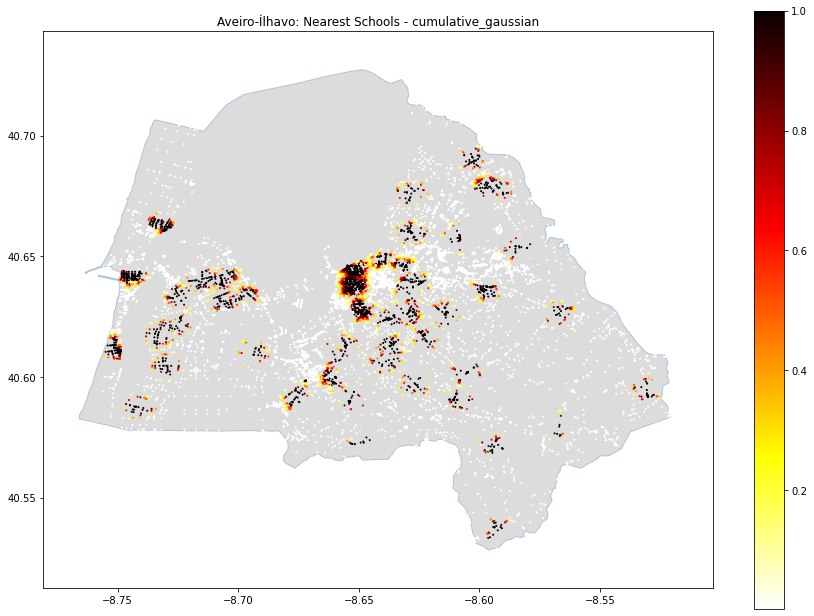

In [70]:
plot_functions(impedance, 1)
plot_functions(impedance, 'cumulative')
plot_functions(impedance, 'inverse_power')
plot_functions(impedance, 'negative_exponential')
plot_functions(impedance, 'modified_gaussian')
plot_functions(impedance, 'cumulative_gaussian')

In [60]:
50**(-0.709)

0.06243530921425346

In [35]:
np.exp(- (1**2)  / 14427)

0.9999306879223983

In [36]:
np.exp(-0.003*1)

0.997004495503373

In [ ]:
np.exp(-0.005*200)

In [ ]:
np.exp(-0.007*200)

In [ ]:
np.exp(-0.010*200)

In [ ]:
np.exp(- (100**2 )/14427 )

In [ ]:
np.exp(- (200**2 )/57708 )

In [ ]:
np.exp(- (300**2 )/129843 )

In [ ]:
np.exp(- (400**2 )/230831 )

In [ ]:
np.log(np.e)